In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [6]:
def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)),X])

def linear_regression_fit(X,y):
    X_bias = add_bias(X)
    beta = np.linalg.inv(X_bias.T @ X_bias) @ X_bias.T @ y
    return beta

def linear_regression_predict(X,beta):
    X_bias = add_bias(X)
    return X_bias @ beta

In [7]:
X = np.array([[1], [2], [3], [4]])
y = np.array([2, 4, 6, 8])

beta = linear_regression_fit(X, y)
y_pred = linear_regression_predict(X, beta)

print("Coefficients", beta)
print("Predictions", y_pred)

Coefficients [-3.10862447e-15  2.00000000e+00]
Predictions [2. 4. 6. 8.]


In [15]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)

print("Coefficients", model.coef_)
print("y-Intercept", model.intercept_)
print("Predictions", y_pred)

Coefficients [2.]
y-Intercept 0.0
Predictions [2. 4. 6. 8.]


In [6]:
def linear_regression_gd(X,y, lr=0.01, n_iters = 1000):
    X = np.array(X)
    y = np.array(y)
    X_bias = add_bias(X)
    n_samples, n_features = X_bias.shape

    beta = np.zeros(n_features)

    for _ in range(n_iters):
        y_pred = X_bias @ beta
        gradient = -(2/n_samples) * X_bias.T @ (y - y_pred)
        beta -= lr*gradient
    return beta

In [7]:
X = np.array([[1], [2], [3], [4]])
y = np.array([2, 4, 6, 8])

beta = linear_regression_gd(X, y)
y_pred = linear_regression_predict(X, beta)

print("Coefficients", beta)
print("Predictions", y_pred)

Coefficients [0.03040452 1.98965876]
Predictions [2.02006328 4.00972203 5.99938079 7.98903954]


In [8]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_parquet("/Users/tobiasshin/Downloads/drw-crypto-market-prediction/train.parquet")

In [9]:
print(df.head())
print(df.shape)


                     bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
timestamp                                                                     
2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   
2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.072944   
2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.173820   

                           X2        X3        X4        X5  ...      X882  \
timestamp                                                    ...             
2023-03-01 00:00:00 -0.417690  0.005399  0.125948  0.058359  ...  1.925423   
2023-03-01 00:01:00 -0.049576  0.356667  0.481087  0.237954  ...  1.928569   
2023-03-01 00:02:00 -0.291212  0.083138  0.206881  0.101727  ...  1.928047   
2023-03-01 00:03:00 -0.436590 -0.102483  0.017551  0.007

In [10]:
print(df.columns)

Index(['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3',
       'X4', 'X5',
       ...
       'X882', 'X883', 'X884', 'X885', 'X886', 'X887', 'X888', 'X889', 'X890',
       'label'],
      dtype='object', length=896)


In [32]:
missing = df.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0])

Series([], dtype: float64)


In [11]:
from sklearn.preprocessing import StandardScaler

def linear_regression_sgd(X, y, lr=0.01, n_epochs=10):
    X = np.array(X)
    y = np.array(y)
    X_bias = add_bias(X)
    n_samples, n_features = X_bias.shape

    beta = np.zeros(n_features)

    for epoch in range(n_epochs):
        #shuffle data at each epoch
        indices = np.random.permutation(n_samples)
        X_bias_shuffled = X_bias[indices]
        y_shuffled = y[indices]
        
        for i in range(n_samples):
            xi = X_bias_shuffled[i].reshape(1,-1) #shape (1,n_features)
            yi = y_shuffled[i]
            
            y_pred_i = xi @ beta
            gradient = -2 * xi.T @ (yi - y_pred_i) #shape (n_features,1)
            beta = beta - lr*gradient.flatten()
    
    return beta
    

In [27]:
# features that are all constant (variance 0)
zero_var = df.loc[:, df.nunique() == 1]
df = df.drop(columns=zero_var)
print(zero_var.columns)

Index(['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705',
       'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714',
       'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872'],
      dtype='object')


In [36]:
correlations = df.corr(numeric_only=True)["label"].drop("label")
top_corr = correlations.abs().sort_values(ascending=False)
print(top_corr.head(10))  # top 10 features strongest correlated with label

X21     0.069401
X20     0.067667
X28     0.064092
X863    0.064057
X29     0.062339
X19     0.062293
X27     0.062251
X22     0.057676
X858    0.057320
X219    0.056713
Name: label, dtype: float64


In [37]:
from sklearn.feature_selection import VarianceThreshold

# drop features with low variance 
selector = VarianceThreshold(threshold=1e-5)
selector.fit(df)

df = df.loc[:, selector.get_support()]
print(df.shape)

(525887, 869)


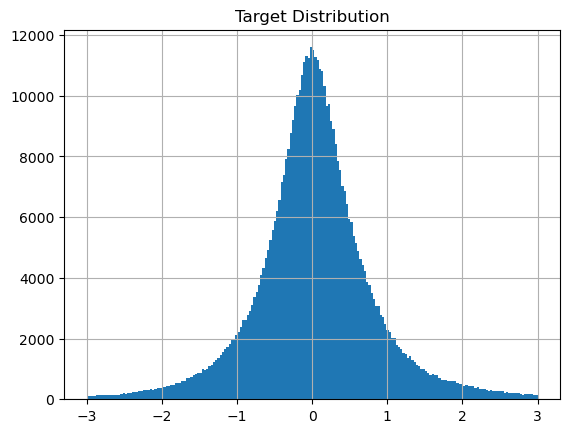

In [28]:
df["label"].hist(bins=200, range=(-3, 3))
plt.title("Target Distribution")
plt.show()

In [29]:
df["label"].describe()

count    525887.000000
mean          0.036126
std           1.009914
min         -24.416615
25%          -0.381585
50%           0.016262
75%           0.434135
max          20.740270
Name: label, dtype: float64

In [30]:
# drop the label from the design matrix and re-assign it
X = df.drop(columns=["label"]).values
y = df["label"].values     

In [39]:
df = df.sort_values("timestamp")

#Let's train on a small subset of the data first to find which features are most prominent
subset = df.iloc[:50_000] #10% of 500,000 timestamps (rows)
train = subset.iloc[:40_000]
val = subset.iloc[40_000:]

In [40]:
X_train, y_train = train.drop(columns=["label"]), train["label"]
X_val, y_val = val.drop(columns=["label"]), val["label"]

#small example where we train and validate the first 10% of our training data
feature_scores = {}

for feature in X_train.columns:
    model = Ridge()
    model.fit(X_train[[feature]], y_train)
    preds = model.predict(X_val[[feature]])
    mse = mean_squared_error(y_val,preds)
    feature_scores[feature] = mse

#sort by lowest MSE
top_features = sorted(feature_scores.items(), key=lambda x: x[1])
for feat, score in top_features[:10]:
    print(f"{feat}: MSE = {score:.4f}")

X866: MSE = 0.5890
X858: MSE = 0.5944
X184: MSE = 0.5981
X22: MSE = 0.5984
X190: MSE = 0.5984
X32: MSE = 0.5985
X344: MSE = 0.5988
X187: MSE = 0.5989
X24: MSE = 0.5992
X853: MSE = 0.5992


In [41]:
#Now we do a sliding window where we do ridge regression for each 10% block (80/20 in each block)
# and then average the MSEs across blocks
# this is with ridge regression

block_size = 50_000
train_frac = 0.8
feature_scores = {}

for block_start in range(0, len(df), block_size):
    block_end = block_start + block_size
    block = df.iloc[block_start:block_end]

    if len(block) < block_size:
        break #skip last partial block

    train_size = int(train_frac*block_size)
    train = block.iloc[:train_size]
    val = block.iloc[train_size:]

    X_train = train.drop(columns=["label"])
    y_train = train["label"]
    X_val = val.drop(columns=["label"])
    y_val = val["label"]

    for feature in X_train.columns:
        model = Ridge()
        model.fit(X_train[[feature]], y_train)
        preds = model.predict(X_val[[feature]])
        mse = mean_squared_error(y_val,preds)

        if feature not in feature_scores:
            feature_scores[feature] = []
        feature_scores[feature].append(mse)

average_scores = { feat: np.mean(mse_list) for feat, mse_list in feature_scores.items() } 

top_features = sorted(average_scores.items(), key=lambda x:x[1])
for feat, score in top_features[:10]:
    print(f"{feat}: Avg MSE = {score:.4f}")
    

X279: Avg MSE = 1.1143
X278: Avg MSE = 1.1177
X277: Avg MSE = 1.1245
X272: Avg MSE = 1.1273
X572: Avg MSE = 1.1280
X296: Avg MSE = 1.1281
X294: Avg MSE = 1.1286
X292: Avg MSE = 1.1293
X565: Avg MSE = 1.1298
X298: Avg MSE = 1.1304


In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


block_size = 50_000
train_frac = 0.8
feature_scores = {}

for block_start in range(0, len(df), block_size):
    block_end = block_start + block_size
    block = df.iloc[block_start:block_end]

    if len(block) < block_size:
        break #skip last partial block

    train_size = int(train_frac*block_size)
    train = block.iloc[:train_size]
    val = block.iloc[train_size:]

    X_train = train.drop(columns=["label"])
    y_train = train["label"]
    X_val = val.drop(columns=["label"])
    y_val = val["label"]

    Xf_train = X_train[[feature]].values
    Xf_val = X_val[[feature]].values

    

    for feature in X_train.columns:

        beta = linear_regression_sgd(Xf_train, y_train.values, lr=0.001, n_epochs=5)
        preds = linear_regression_predict(Xf_val, beta)
        mse = mean_squared_error(y_val.values,preds)

        if feature not in feature_scores:
            feature_scores[feature] = []
        feature_scores[feature].append(mse)

average_scores = { feat: np.mean(mse_list) for feat, mse_list in feature_scores.items() } 

top_features = sorted(average_scores.items(), key=lambda x:x[1])
for feat, score in top_features[:10]:
    print(f"{feat}: Avg MSE = {score:.4f}")

X528: Avg MSE = 1.1385
X760: Avg MSE = 1.1390
X306: Avg MSE = 1.1393
X27: Avg MSE = 1.1412
X246: Avg MSE = 1.1415
X779: Avg MSE = 1.1421
X365: Avg MSE = 1.1425
X65: Avg MSE = 1.1426
X613: Avg MSE = 1.1433
X209: Avg MSE = 1.1437


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np

block_size = 50_000
train_frac = 0.8
feature_scores = {}

for block_start in range(0, len(df), block_size):
    block_end = block_start + block_size
    block = df.iloc[block_start:block_end]

    if len(block) < block_size:
        break

    train_size = int(train_frac * block_size)
    train = block.iloc[:train_size]
    val = block.iloc[train_size:]

    X_train = train.drop(columns=["label"])
    y_train = train["label"]
    X_val = val.drop(columns=["label"])
    y_val = val["label"]

    for feature in X_train.columns:
        Xf_train = X_train[[feature]].values
        Xf_val = X_val[[feature]].values

        model = Ridge(alpha=1.0)
        model.fit(Xf_train, y_train)
        preds = model.predict(Xf_val)
        mse = mean_squared_error(y_val, preds)

        if feature not in feature_scores:
            feature_scores[feature] = []
        feature_scores[feature].append(mse)

In [ ]:
import pickle

# Save
with open("feature_scores.pkl", "wb") as f:
    pickle.dump(feature_scores, f)

# Later: Load it back
with open("feature_scores.pkl", "rb") as f:
    feature_scores = pickle.load(f)

In [ ]:
#Rerun this cell to load obtained data

average_scores = { feat: np.mean(mse_list) for feat, mse_list in feature_scores.items() } 
top_features = sorted(average_scores.items(), key=lambda x: x[1])
for feat, score in top_features[:20]:
    print(f"{feat}: Avg MSE = {score:.4f}")

In [16]:
# 1. Get top MSE features from your feature_scores dictionary
top_mse_features = sorted(average_scores.items(), key=lambda x: x[1])[:20]
top_mse_feature_names = [feat for feat, _ in top_mse_features]

# 2. Get top correlation features
correlations = df.corr(numeric_only=True)["label"].drop("label")
top_corr_features = correlations.abs().sort_values(ascending=False).head(20).index.tolist()

# 3. Compare
print("Overlap between top-MSE and top-correlation features:")
print(set(top_mse_feature_names) & set(top_corr_features))

NameError: name 'average_scores' is not defined